# MHKit River 

This jupyter notebook will familiarize the user with the mhkit river module by stepping through the calculation of annual energy produced for one turbine in the Tanana river near Nenana. First, let us load the River module. Below we import 3 standard python packages. Pandas, numpy, and matplotlib. With respect to MHKit, all of the river functions are imported with respect to each of the functional groupings. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mhkit.river import device, resource, graphics, io

## Importing Data from USGS
   
We will start by requesting daily discharge data from USGS for the Tanana River near Nenana. The function request_usgs_data in the MHKit river IO module returns a Pandas DataFrame. To use the request_usgs_data function we will need a station number, parameter number, time frame and type of data. The station ID can be found on the USGS website though this is more difficult than searching the web for "USGS Tanana near Nenana" which should return a link to https://waterdata.usgs.gov/nwis/inventory/?site_no=15515500. This page contains an overview of the available data of most interest in the daily discharge data. The IEC standard recommends 10 years of daily discharge data for calculations of annual energy produced (AEP). The timeframe shows that at least 10 years of data is available. Clicking on the "Daily Data" will bring up a page that would allow the user to request data from the site. Each of the "Available Parameters" has a 5 digit code in front of it which will depend on the data type and reported units. The user at this point could use the website to download the data, however, here the MHKit request function will be used. 

In [2]:
# Use the requests method to obtain 10 years of daily discharge data
data = io.request_usgs_data(station="15515500",
                            parameter='00060',
                            start_date='2009-08-01',
                            end_date='2019-08-01',
                            data_type='Daily')



# Print data
print(data)

Data request URL:  https://waterservices.usgs.gov/nwis/dv/?format=json&sites=15515500&startDT=2009-08-01&endDT=2019-08-01&statCd=00003&parameterCd=00060&siteStatus=all
                           Discharge, cubic feet per second
2009-08-01 00:00:00+00:00                             59100
2009-08-02 00:00:00+00:00                             59700
2009-08-03 00:00:00+00:00                             56200
2009-08-04 00:00:00+00:00                             51700
2009-08-05 00:00:00+00:00                             52100
...                                                     ...
2019-07-28 00:00:00+00:00                             66000
2019-07-29 00:00:00+00:00                             63900
2019-07-30 00:00:00+00:00                             63500
2019-07-31 00:00:00+00:00                             64700
2019-08-01 00:00:00+00:00                             64600

[3653 rows x 1 columns]


The request_usgs_data has returned a pandas DataFrame with 10 years of daily discharge indexed by time. The key name "Discharge, cubic feet per second" is long and therefore will be renamed to "Q". Further, MHKit expects all units to be in SI so the discharge values will be converted to $m^3/s$. Fianlly we can plot the discharge time series.

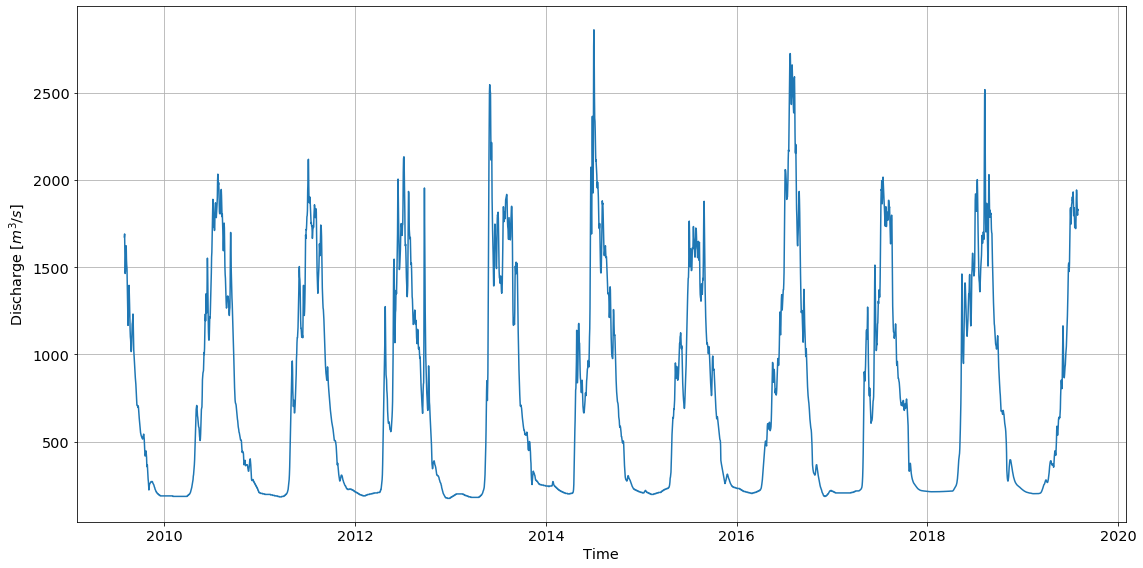

In [3]:
# Store the long DataFrame key name
key = data.keys()[0]

# Rename to a shorter key name e.g. 'Q'
data = data.rename(columns={key: 'Q'})

# Convert to discharge data from ft3/s to m3/s
data.Q = data.Q / (3.28084)**3

# Plot the daily discharge 
graphics.plot_discharge_timeseries(data.Q)

## The Flow Duration Curve

The flow duration curve (FDC) quantifies the percentage of time that the discharge in a river exceeds a particular magnitude typically compiled on a monthly or annual basis. The FDC is a plot of discharge versus exceedance probability. The exceedance probability for the highest discharge is close to 0%, rarely being exceeded. Conversely, the lowest flowrates are found closer to 100% as they are most often exceeded.

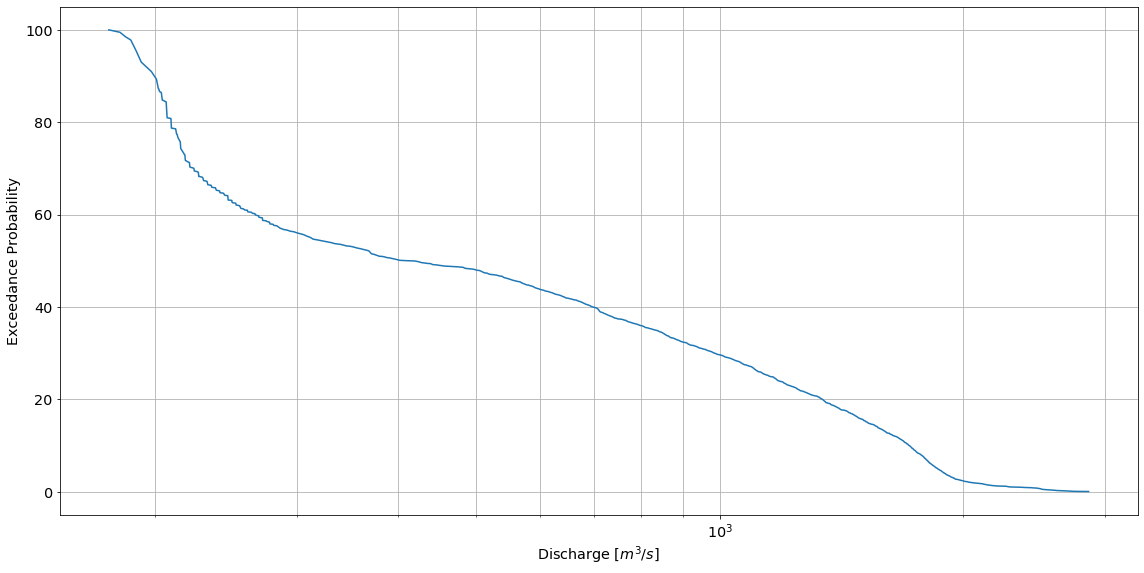

In [4]:
# Calculate & plot the exceedence probability
data['F'] = resource.exceedance_probability(data.Q)
# Plot the flow duration curve (FDC)
graphics.plot_flow_duration_curve(data.Q, data.F )

## Velocity Duration Curve

At each river energy converter location we must provide a curve that relates the velocity at the turbine location to the river discharge levels. IEC 301 recommends using at least 15 different discharges and that only velocities within the turbine operating conditions need to be included. Here we only provide 6 different discharge to velocities created using a hydrological model. 

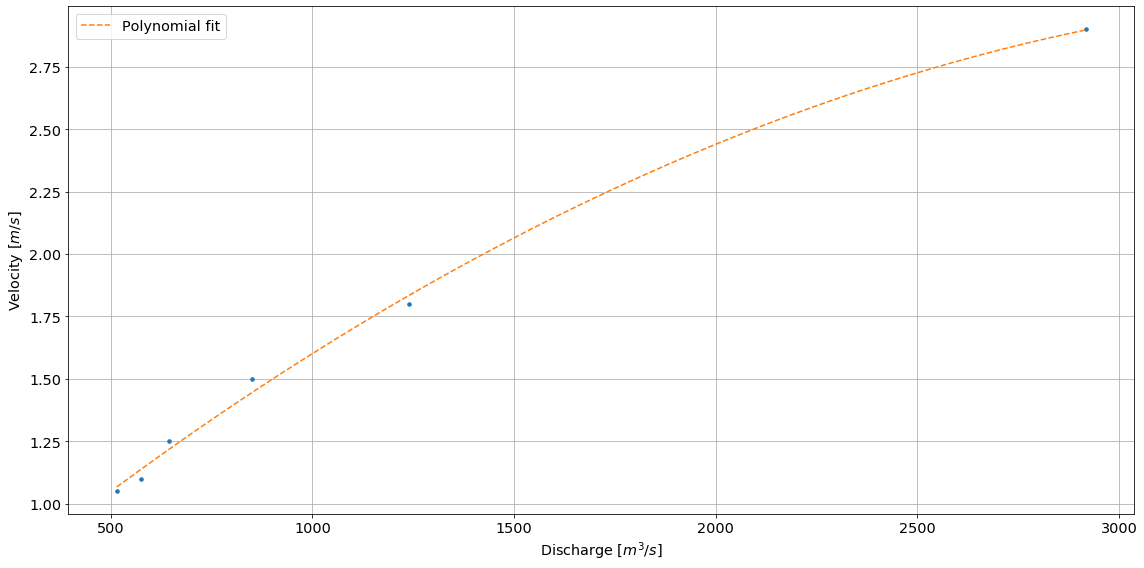

In [5]:
# Import discharge to velocity curve at turbine location
DV_curve = pd.read_csv('../mhkit/tests/data/tanana_DV_curve.csv')

# Create a polynomial fit of order 2 from the DV_curve. The polynomial
#  fit function will return a polynomial fit & and R**2 value.
p, r2 = resource.polynomial_fit(DV_curve['D'], DV_curve['V'], 2)

# Plot the polynomial curve
ax = graphics.plot_discharge_vs_velocity(DV_curve['D'], 
                                    DV_curve['V'], 
                                    polynomial_coeff=p)

The IEC standard recommends a polynomial fit of order 3. By changing the order above and replotting the polynomial fit to the curve data it can be seen this is not a good fit for the provided data. Therefore the order was set to 2. Next, we can calculate velocity for each discharge in the 10 years years of data using the polynomial 'p'. Finally, we may plot the VDC.

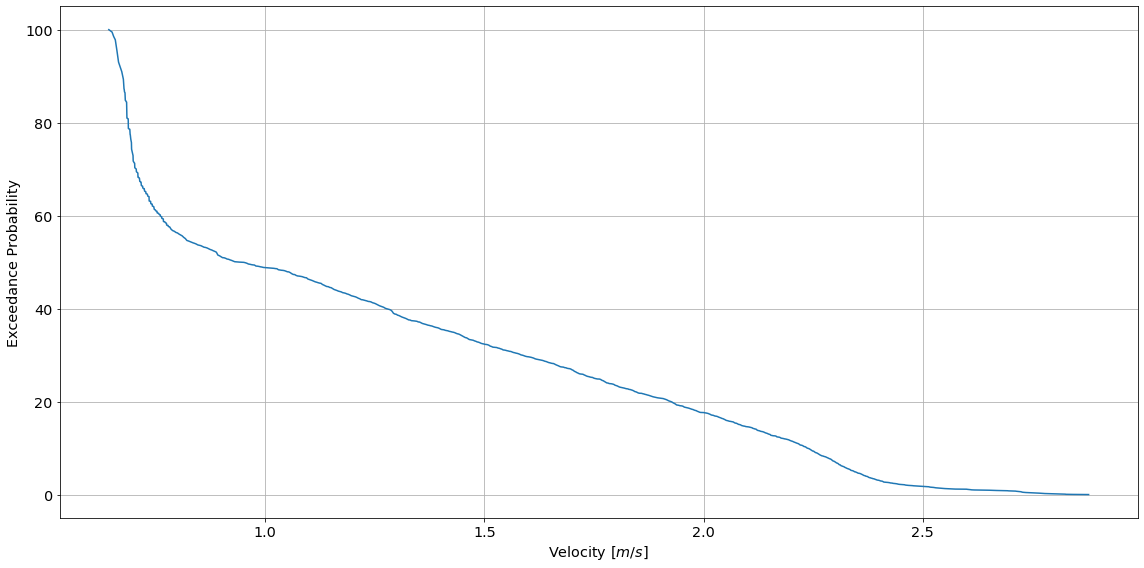

In [6]:
# Use polynomial fit from DV curve to calculate velocity('V') from 
#  discharge at turbine location
data['V'] = resource.discharge_to_velocity(data['Q'], p)

# Plot the velocity duration curve (VDC) 
graphics.plot_velocity_duration_curve(data.V, data.F )

# Power Duration Curve 
The power duration curve is created in a nearly identical manner to the VDC. Here a velocity to power curve will be used to create a polynomial fit. The polynomial fit will be used to calculate the power produced between the turbine cut-in and cut-out velocities. 

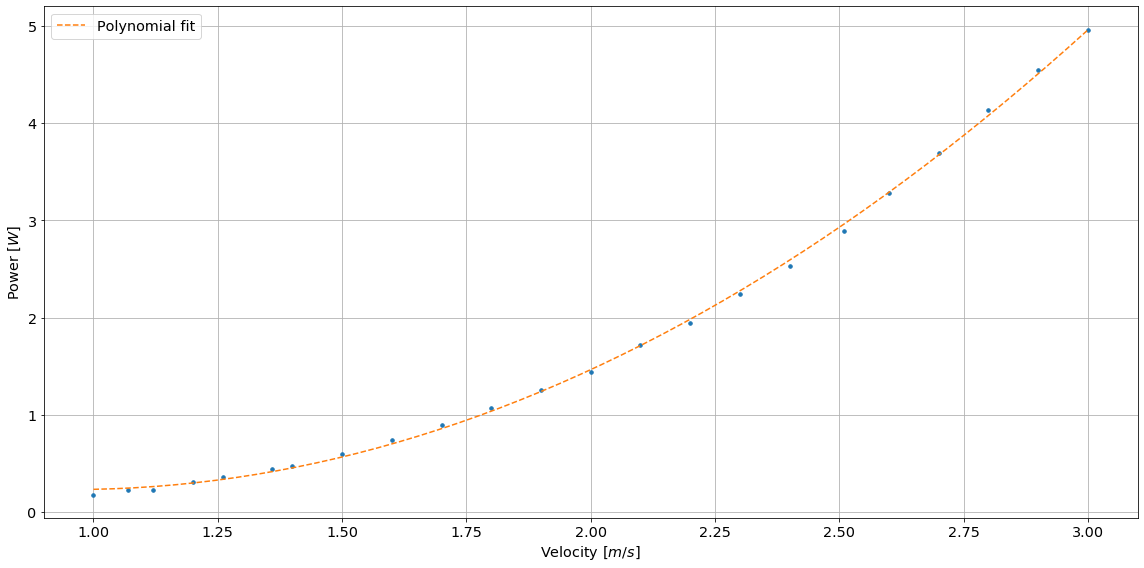

In [7]:
# Calculate the power produced from turbine velocity to power curve
VP_curve = pd.read_csv('../mhkit/tests/data/tanana_VP_curve.csv')
# Calculate the polynomial fit for the VP curve
p2, r22 = resource.polynomial_fit(VP_curve['V'], VP_curve['P'],2)
# Plot the VP polynomial curve
graphics.plot_velocity_vs_power(VP_curve['V'], VP_curve['P'], polynomial_coeff=p2)

The second-order polynomial fits the data well. Therefore we will use the polynomial to calculate the power using the min and max of the curves velocities as the turbine operational limits.

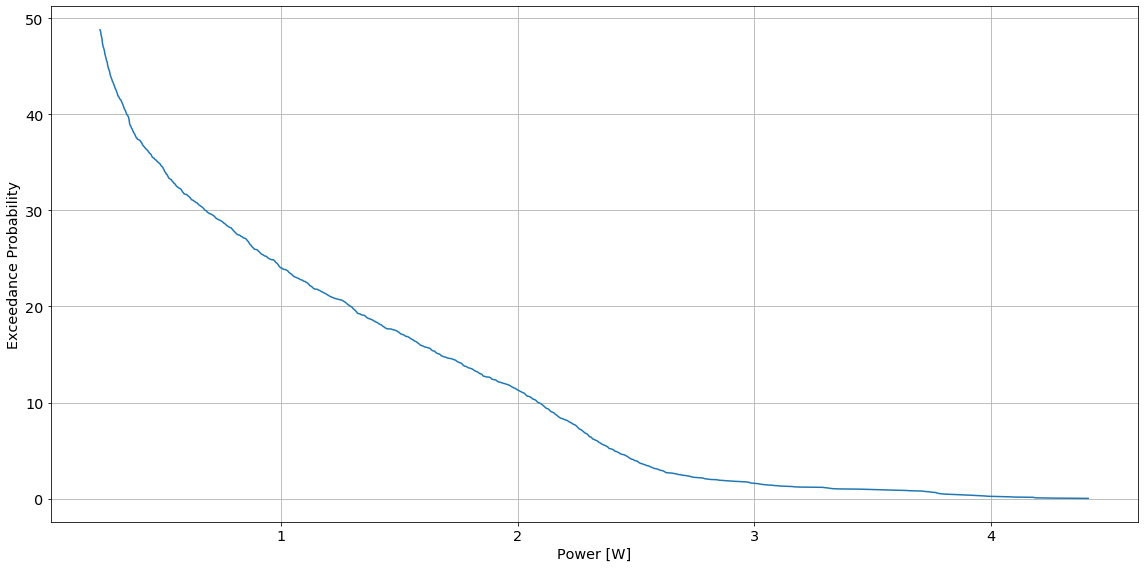

In [8]:
# Calculate power from velocity at the turbine location
data['P']=resource.velocity_to_power(data['V'], 
                                     polynomial_coefficients=p2,
                                     cut_in=VP_curve.V.min(), 
                                     cut_out=VP_curve.V.max())
# Plot the power duration curve
graphics.plot_power_duration_curve(data.P, data.F )

In [9]:
# Calculate the Annual Energy produced
s= 365. * 24 * 3600 # Seconds in a year
AEP = resource.energy_produced(data.F, data.P, s)
print(f"Annual Energy Produced: {AEP/1000000:.2f} MW")


Annual Energy Produced: 100.75 MW
